This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Geometrical EBSD simulations

This section details how to inspect and visualize the results from pattern
matching or Hough indexing by plotting Kikuchi bands and zone axes onto an EBSD
signal. We consider this a geometrical EBSD simulation, since it's only the
Kikuchi band centres and zone axis positions that will be computed. These
simulations are based on the work by Aimo Winkelmann in the supplementary
material to <cite data-cite="britton2016tutorial">Britton et al. (2016)</cite>.

Let's import the necessary libraries and a small (3, 3) Nickel EBSD test data
set

In [1]:
# exchange inline for qt5 for interactive plotting from the pyqt package
%matplotlib inline

import tempfile
from diffsims.crystallography import ReciprocalLatticePoint
import hyperspy.api as hs
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import numpy as np
from orix import crystal_map, quaternion, vector
import kikuchipy as kp


s = kp.data.nickel_ebsd_small()  # Use kp.load("data.h5") to load your own data
s

<EBSD, title: patterns My awes0m4 ..., dimensions: (3, 3|60, 60)>

Let's enhance the Kikuchi bands by removing the static and dynamic backgrounds

In [2]:
s.remove_static_background()
s.remove_dynamic_background()

Removing the static background:
[########################################] | 100% Completed |  0.5s
Removing the dynamic background:
[########################################] | 100% Completed |  0.3s


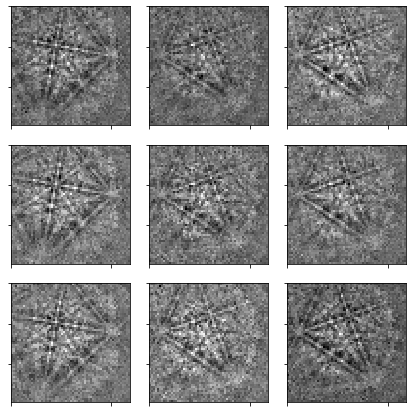

In [3]:
_ = hs.plot.plot_images(
    s, axes_decor=None, label=None, colorbar=False, tight_layout=True
)

To project Kikuchi bands and zone axis positions onto our detector, we need
1. a description of the crystal phase, in the geometrical case only the space
   group
2. the set of Kikuchi bands to consider, e.g. the {111}, {200}, {220}, and {311}
   crystal plane families
3. the crystal orientations with respect to the reference frame
4. the position of the detector with respect to the sample reference frame,
   in the form of a sample-detector model which includes the sample and detector
   tilt and the projection center (shortes distance from the source point on the
   sample to the detector), given here as (PC$_x$, PC$_y$, PC$_z$)

We'll store the crystal phase information in an
[orix.crystal_map.Phase](https://orix.readthedocs.io/en/stable/reference.html#orix.crystal_map.phase_list.Phase)
instance

In [4]:
phase = crystal_map.Phase(name="ni", space_group=225)
phase

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

We'll set up the relevant Kikuchi bands (and the zone axes from these) in a
[diffsims.crystallography.ReciprocalLatticePoint](https://diffsims.readthedocs.io/en/latest/reference.html#diffsims.crystallography.ReciprocalLatticePoint)
instance

In [5]:
rlp = ReciprocalLatticePoint(
    phase=phase, hkl=[[1, 1, 1], [2, 0, 0], [2, 2, 0], [3, 1, 1]]
)
rlp

ReciprocalLatticePoint (4,)
Phase: ni (m-3m)
[[1 1 1]
 [2 0 0]
 [2 2 0]
 [3 1 1]]

We can get a new instance with the symmetrically equivalent planes in each
plane family using
[ReciprocalLatticePoint.symmetrise()](https://diffsims.readthedocs.io/en/latest/reference.html#diffsims.crystallography.ReciprocalLatticePoint.symmetrise)

In [6]:
rlp2 = rlp.symmetrise()
rlp2

ReciprocalLatticePoint (50,)
Phase: ni (m-3m)
[[ 1  1  1]
 [-1  1  1]
 [-1 -1  1]
 [ 1 -1  1]
 [ 1 -1 -1]
 [ 1  1 -1]
 [-1  1 -1]
 [-1 -1 -1]
 [ 2  0  0]
 [ 0  2  0]
 [-2  0  0]
 [ 0 -2  0]
 [ 0  0  2]
 [ 0  0 -2]
 [ 2  2  0]
 [-2  2  0]
 [-2 -2  0]
 [ 2 -2  0]
 [ 0  2  2]
 [-2  0  2]
 [ 0 -2  2]
 [ 2  0  2]
 [ 0  2 -2]
 [-2  0 -2]
 [ 0 -2 -2]
 [ 2  0 -2]
 [ 3  1  1]
 [-1  3  1]
 [-3 -1  1]
 [ 1 -3  1]
 [ 1  3  1]
 [-3  1  1]
 [-1 -3  1]
 [ 3 -1  1]
 [ 3 -1 -1]
 [ 1  3 -1]
 [-3  1 -1]
 [-1 -3 -1]
 [-1  3 -1]
 [-3 -1 -1]
 [ 1 -3 -1]
 [ 3  1 -1]
 [ 1 -1  3]
 [ 1  1  3]
 [-1  1  3]
 [-1 -1  3]
 [-1 -1 -3]
 [ 1 -1 -3]
 [ 1  1 -3]
 [-1  1 -3]]

We know from [pattern matching](pattern_matching.ipynb) of these nine patterns,
to about 7 500 dynamically simulated patterns of orientations uniformly
distributed in the orientation space of the point group $m\bar{3}m$, that they
come from two grains with orientations of about $(\phi_1, \Phi, \phi_2) =
(80^{\circ}, 34^{\circ}, -90^{\circ})$ and $(\phi_1, \Phi, \phi_2) =
(115^{\circ}, 27^{\circ}, -95^{\circ})$. We store these orientations in an
[orix.quaternion.Rotation](https://orix.readthedocs.io/en/stable/reference.html#orix.quaternion.rotation.Rotation)
instance

In [7]:
grain1 = [80, 34, -90]
grain2 = [115, 27, -95]
r = quaternion.Rotation.from_euler(np.deg2rad([
        [grain1, grain1, grain2],
        [grain1, grain1, grain2],
        [grain1, grain1, grain2]
]))
r

Rotation (3, 3)
[[[ 0.9527 -0.0255 -0.2913  0.0833]
  [ 0.9527 -0.0255 -0.2913  0.0833]
  [ 0.9576  0.0604 -0.2255 -0.1689]]

 [[ 0.9527 -0.0255 -0.2913  0.0833]
  [ 0.9527 -0.0255 -0.2913  0.0833]
  [ 0.9576  0.0604 -0.2255 -0.1689]]

 [[ 0.9527 -0.0255 -0.2913  0.0833]
  [ 0.9527 -0.0255 -0.2913  0.0833]
  [ 0.9576  0.0604 -0.2255 -0.1689]]]

We describe the sample-detector model in an
[kikuchipy.detectors.EBSDDetector](reference.rst#kikuchipy.detectors.ebsd_detector.EBSDDetector)
instance. From Hough indexing we know the projection center to be, in the EDAX
TSL convention (see the [reference frame](reference_frames.rst) guide for the
various conventions and more details on the use of the sample-detector model),
$(x^{*}, y^{*}, z^{*}) = (0.421, 0.7794, 0.5049)$. The sample was tilted
$70^{\circ}$ about the microscope X direction towards the detector, and the
detector normal was orthogonal to the optical axis (beam direction)

In [8]:
detector = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    sample_tilt=70,
    pc=[0.421, 0.7794, 0.5049],
    convention="tsl"
)
detector

EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, pc (0.421, 0.221, 0.505)

Note that the projection center gets converted internally to the Bruker
convention.

Let's create an
[EBSDSimulationGenerator](reference.rst#kikuchipy.generators.EBSDSimulationGenerator)
instance

In [ ]:
r_tsl2bruker = quaternion.Rotation.from_neo_euler(
    vector.neo_euler.AxAngle.from_axes_angles(
        axes=vector.Vector3d.zvector(),
        angles=np.pi / 2
    )
)
r_tsl2bruker

In [9]:
sim_gen = kp.generators.EBSDSimulationGenerator(
    detector=detector,
    phase=phase,
    rotations=r# * r_tsl2bruker
)
sim_gen

EBSDSimulationGenerator (3, 3)
EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, pc (0.421, 0.221, 0.505)
<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
Rotation (3, 3)

Now we're ready to simulate geometrical EBSD patterns from the generator and the
sets of crystal plane families

In [10]:
sim = sim_gen.geometrical_simulation(reciprocal_lattice_point=rlp2)
sim

GeometricalEBSDSimulation (3, 3)
EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0, pc (0.421, 0.221, 0.505)
<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>
KikuchiBand (3, 3|27)
Rotation (3, 3)

We see that 27 of the 50 Kikuchi bands we're visible on the detector in the nine
patterns, stored in an instance of the
[kikuchipy.simulations.features.KikuchiBand](reference.rst#kikuchipy.simulations.features.KikuchiBand)
class, which is a class inheriting from the
[ReciprocalLatticePoint](https://diffsims.readthedocs.io/en/latest/reference.html#diffsims.crystallography.ReciprocalLatticePoint)

In [11]:
sim.bands

KikuchiBand (3, 3|27)
Phase: ni (m-3m)
[[ 1  1  1]
 [-1  1  1]
 [-1 -1  1]
 [ 1 -1  1]
 [ 0  2  0]
 [-2  0  0]
 [ 0 -2  0]
 [ 0  0  2]
 [-2  2  0]
 [-2 -2  0]
 [ 2 -2  0]
 [ 0  2  2]
 [-2  0  2]
 [ 0 -2  2]
 [ 2  0  2]
 [ 3  1  1]
 [-1  3  1]
 [-3 -1  1]
 [ 1 -3  1]
 [ 1  3  1]
 [-3  1  1]
 [-1 -3  1]
 [ 3 -1  1]
 [ 1 -1  3]
 [ 1  1  3]
 [-1  1  3]
 [-1 -1  3]]

In [12]:
sim.zone_axes.size

91

We also see that there are 91 zone axes resulting from the 27 Kikuchi bands,
stored in an instance of the
[kikuchipy.simulations.features.ZoneAxis](reference.rst#kikuchipy.simulations.features.ZoneAxis)
class, also inheriting from `ReciprocalLatticePoint`.

We can now add these simulations as markers to be displayed on top of our
experimental EBSD signal when plotting

In [13]:
markers = sim.as_markers(pc=False)
s.add_marker(marker=markers, plot_marker=False, permanent=True)

The markers update with the pattern when navigating, thus helping us determine
whether an indexing was successful, and in labeling the bands and zone axes in
the pattern

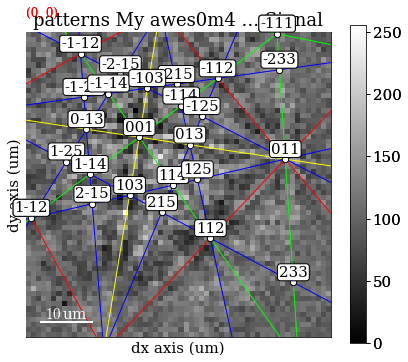

In [14]:
s.plot(navigator=None)

Whether to plot only bands, zone axes, zone axes labels, projection center, or
all of them, can be set in the
[GeometricalEBSDSimulation.as_markers()](reference.rst#kikuchipy.simulations.GeometricalEBSDSimulation.as_markers)
method. Their appearance on the pattern can also be controlled to some extent.
The above method itself calls
[bands_as_markers()](reference.rst#kikuchipy.simulations.GeometricalEBSDSimulation.bands_as_markers),
[pc_as_markers()](reference.rst#kikuchipy.simulations.GeometricalEBSDSimulation.pc_as_markers),
[zone_axes_as_markers()](reference.rst#kikuchipy.simulations.GeometricalEBSDSimulation.zone_axes_as_markers),
and [zone_axes_labels_as_markers()](reference.rst#kikuchipy.simulations.GeometricalEBSDSimulation.zone_axes_labels_as_markers).
See their documentation for available modifications.

Let's first remove the markers from the signal, and add only the bands and zone
axes

In [15]:
del s.metadata.Markers
s.add_marker(
    marker=sim.as_markers(
        pc=False,
        zone_axes_labels=False,
        bands_kwargs=dict(
            family_colors=["w", "magenta", "cyan", "lime"], linestyle="--",
        ),
        zone_axes_kwargs=dict(
            marker="s", size=150, facecolor="none", edgecolor="w",
        ),
    ),
    plot_marker=False,
    permanent=True,
)

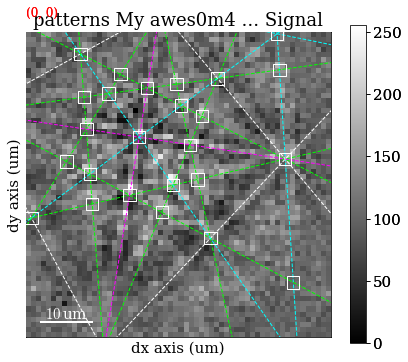

In [16]:
s.plot(navigator=None)

In [17]:
del s.metadata.Markers
s.add_marker(marker=markers, plot_marker=False, permanent=True)

We can write single EBSD patterns with the markers on top to file

In [18]:
fig = s._plot.signal_plot.figure
bbox = matplotlib.transforms.Bbox.from_extents(
    np.array(fig.axes[0].bbox.extents) / 72  # The denominator may vary
)

In [19]:
nav_x, nav_y = s.axes_manager.indices
temp_dir = tempfile.mkdtemp()
fname = temp_dir + f"/geosim_y{nav_y}_x{nav_x}.png"
s._plot.signal_plot.figure.savefig(fname, bbox_inches=bbox, dpi=150)

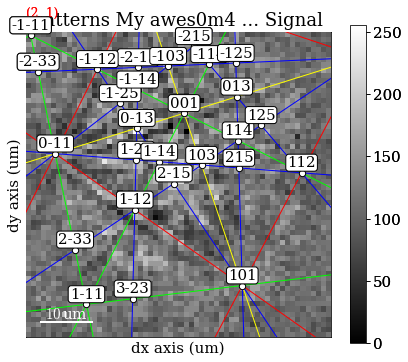

In [20]:
s.axes_manager.indices = (2, 1)
s.plot(navigator=None)

In [21]:
nav_x, nav_y = s.axes_manager.indices
fname = temp_dir + f"/geosim_y{nav_y}_x{nav_x}.png"
s._plot.signal_plot.figure.savefig(fname, bbox_inches=bbox, dpi=150)

The coordinates of these bands and zone axes are available as class attributes.
For the bands, we can e.g. extract the plane trace coordinates (y0, x0, y1, x1)
in either gnomonic or detector coordinates (taking into account the detector
size in pixels) for all bands or per navigation position

In [22]:
sim.bands[0, 0].plane_trace_coordinates[:10]  # Gnomonic

array([[-1.86962815,  1.3839786 , -0.44997371,  1.33513632],
       [-0.19287074, -1.71126251, -1.91331823,  0.87724933],
       [ 1.81954214, -0.52126096,  0.62229589, -1.85101939],
       [-0.8909565 ,  1.52423106,  1.70416615, -1.17247834],
       [-0.37289001,  0.25549816, -1.88651499,  1.90596602],
       [ 1.84727965, -1.92275022, -0.53436284,  0.03189612],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [ 0.91928302, -1.2811585 , -1.68905432,  1.43409158],
       [ 1.61490871, -1.45501536,  1.04405729, -1.25734485]])

In [23]:
sim.bands_detector_coordinates[0, 0, :10]  # Detector

array([[-30.85553999,  26.41971173,  66.06647692, -26.75710942],
       [ 19.09355422,  70.01142803, -26.13796996, -13.11706816],
       [ 79.0415227 ,  -5.52223447,   9.31110502,  68.15560163],
       [ -1.70179228, -37.75017597,  70.24447135,  47.94247445],
       [ 13.73094208,  69.21298364,  32.45006018, -43.76161226],
       [ 79.86779834,  28.93358806, -32.43799853,  12.06524342],
       [         nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan],
       [ 52.22361382,  63.33080802, -13.32555877, -29.70489743],
       [ 72.94567699, -18.08612708, -18.50459793,  50.47057156]])

The NaN values signify that that particular band is not visible on the detector
in that position. The crystal plane normal of each band, pointing from the
source point to the detector, is also available

In [24]:
sim.bands[1, 1].hkl_detector[:10]

Vector3d (10,)
[[ 0.7437 -1.3556  0.7806]
 [ 1.0317  0.5613  1.273 ]
 [-0.9379  0.8877  1.1542]
 [-1.2259 -1.0292  0.6618]
 [ 1.9696 -0.3264  0.1188]
 [ 0.2879  1.9169  0.4925]
 [-1.9696  0.3264 -0.1188]
 [-0.1942 -0.4679  1.9348]
 [ 2.2575  1.5906  0.6112]
 [-1.6817  2.2433  0.3737]]

And where the vector hits the detector, in either detector or gnomonic
coordinates

In [25]:
sim.bands[0, 0].x_detector

array([ 0.74374406,  1.03166579, -0.93794972, -1.22587145,  1.96961551,
        0.28792173, -1.96961551, -0.19420566,  2.25753723, -1.68169378,
       -2.25753723,  1.77540985,  0.09371607, -2.16382116, -0.48212738,
        0.45582233,  3.00128129, -0.65002799, -3.19548695,  2.71335957,
        1.31958752, -2.90756522, -1.51379317, -1.4200771 ,  0.5495384 ,
        0.83746013, -1.13215538])

In [26]:
sim.bands[0, 0].x_gnomonic

array([ 0.95284409,  0.81041393, -0.81262043, -1.852415  , 16.58171874,
        0.58466103, 16.58171874, -0.10037608,  3.69336327, -4.50039545,
        3.69336327,  0.86455112,  0.03861015, -1.19153285, -0.3342719 ,
        1.58220857,  2.15641313, -0.39474877, -5.88501573,  3.01707649,
        0.74744255, -2.80803112, -8.94095047, -0.54690929,  0.20238351,
        0.26107065, -0.36651089])

The same information is available for the zone axes

In [27]:
sim.zone_axes_label_detector_coordinates[0, 0][20:30]  # Detector

array([[18.15541142,  6.66929505],
       [        nan,         nan],
       [29.1906983 ,  8.58678901],
       [49.44397197,  5.76573284],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [10.97072449, 11.12462908]])

In [28]:
sim.zone_axes[0, 1].uvw_detector[:10]

Vector3d (10,)
[[-1.1527  5.3526  0.145 ]
 [-1.3469  4.8847  2.0798]
 [-0.4592  4.4876  3.1065]
 [ 1.5104  4.1612  3.2253]
 [ 2.7865  4.6999  0.3825]
 [ 2.5923  4.232   2.3173]
 [-0.5061  3.7631  1.8929]
 [ 1.6578  3.9046  0.0769]
 [ 1.4635  3.4367  2.0117]
 [-2.7167  2.897   2.4953]]

In [29]:
sim.zone_axes[0, 0].y_detector[:10]

array([5.35259241, 4.88471474, 4.4876    , 4.16124817, 4.69988877,
       4.2320111 , 3.76307848, 3.90460433, 3.43672666, 2.89703112])

In [30]:
sim.zone_axes[0, 0].y_gnomonic[:10]

array([36.92063784,  2.3486962 ,  1.44456664,  1.29018168, 12.28599581,
        1.82625189,  1.98797814, 50.76220008,  1.70836955,  1.16099717])

With this information, it should be straight forward to go around kikuchipy
when plotting and only use matplotlib

(3, 3, 27, 4)
(3, 3, 91, 2)


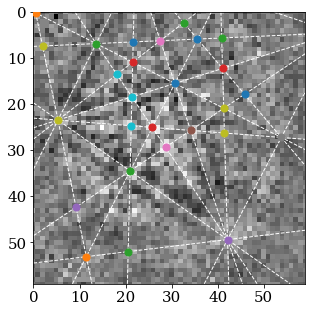

In [31]:
nav_idx = (2, 1)[::-1]

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(s.inav[nav_idx], cmap="gray")

print(sim.bands_detector_coordinates.shape)
for i in np.ndindex(sim.bands_detector_coordinates.shape[2]):
    sim_slice = nav_idx + (i,)
    coords = sim.bands_detector_coordinates[sim_slice][0]
    y0, x0, y1, x1 = coords
    ax.axline((y0, x0), (y1, x1), linestyle="--", color="w")

print(sim.zone_axes_detector_coordinates.shape)
for j in np.ndindex(sim.zone_axes_detector_coordinates.shape[2]):
    sim_slice = nav_idx + (j,)
    coords = sim.zone_axes_detector_coordinates[sim_slice][0]
    x, y = coords
    ax.scatter(x=x, y=y, zorder=5, s=50)

_ = ax.axis((0, 59, 59, 0))

In [32]:
from shutil import rmtree
rmtree(temp_dir)  # Remove files written to disk in this user guide